In [1]:
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import pandas as pd
from datetime import datetime
import time

# # Assuming evaluate is defined elsewhere
# # from your_module import evaluate
import torch.optim as optim

from tqdm.auto import tqdm
from collections.abc import Iterable
import perceval as pcvl
from boson_sampler import BosonSampler
import numpy as np
from scipy.optimize import minimize
import random
import matplotlib.pyplot as plt
from utils import MNIST_partial, accuracy, plot_training_metrics

# from model import MnistModel, evaluate
import torch.nn as nn
import torch.nn.functional as F

# simulator = pcvl.Simulator(pcvl.NaiveBackend())
from scipy.optimize import minimize


from torchmps import MPS

import warnings

warnings.filterwarnings("ignore")

In [2]:
# device = torch.device("cpu")
device = torch.device("cuda:0")

In [3]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 12, kernel_size=5)
        self.fc1 = nn.Linear(12 * 4 * 4, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = x.view(x.size(0), -1)  # [N, 32 * 8 * 8]
        x = self.fc1(x)
        x = self.fc2(x)
        return x


# dataset from csv file, to use for the challenge
train_dataset = MNIST_partial(split="train")
val_dataset = MNIST_partial(split="val")

# definition of the dataloader, to process the data in the model
# here, we need a batch size of 1 to use the boson sampler
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

In [4]:
learning_rate = 1e-3
num_epochs = 1


# Instantiate the model and loss function
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_classical_parameter = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("# of parameters in classical CNN model: ", num_classical_parameter)

# of parameters in classical CNN model:  6690


In [5]:
# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}"
            )

In [6]:
# Testing loop
model.eval()
correct = 0
total = 0
loss_test_list = []
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        loss_test = criterion(outputs, labels).cpu().detach().numpy()
        loss_test_list.append(loss_test)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {(100 * correct / total):.2f}%")

Accuracy on the test set: 70.33%


In [7]:
### required qubits estimation ##############
# NN weights

numpy_weights = {}
nw_list = []
nw_list_normal = []
for name, param in model.state_dict().items():
    numpy_weights[name] = param.cpu().numpy()
for i in numpy_weights:
    nw_list.append(list(numpy_weights[i].flatten()))
for i in nw_list:
    for j in i:
        nw_list_normal.append(j)
print("# of NN parameters: ", len(nw_list_normal))
n_qubits = int(np.ceil(np.log2(len(nw_list_normal))))
print("Required qubit number: ", n_qubits)

n_qubit = n_qubits

#############################################

# of NN parameters:  6690
Required qubit number:  13


In [8]:
### Some tool function definition ###########
def probs_to_weights(probs_):
    new_state_dict = {}
    data_iterator = probs_.view(-1)

    for name, param in CNNModel().state_dict().items():
        shape = param.shape
        num_elements = param.numel()
        chunk = data_iterator[:num_elements].reshape(shape)
        new_state_dict[name] = chunk
        data_iterator = data_iterator[num_elements:]

    return new_state_dict


def generate_qubit_states_torch(n_qubit):
    # Create a tensor of shape (2**n_qubit, n_qubit) with all possible combinations of 0 and 1
    all_states = torch.cartesian_prod(*[torch.tensor([-1, 1]) for _ in range(n_qubit)])
    return all_states


def generate_random_qubit_state_torch(n_qubit):
    # Generate a single random state of size (n_qubit,)
    random_state = torch.randint(0, 2, (n_qubit,)) * 2 - 1  # Converts {0,1} → {-1,1}

    # Repeat this state 2^N times
    repeated_states = random_state.repeat((2**n_qubit, 1))

    return repeated_states


#############################################
def generate_random_tensor():
    return torch.randn(
        126 * 70, 1
    ).cuda()  # Generates a tensor with standard normal distribution


### Main Learning-wise Hybridization model ##


class PhotonicQuantumTrain(nn.Module):
    def __init__(self):
        """ """
        super().__init__()

        self.MappingNetwork = MPS(input_dim=n_qubit + 1, output_dim=1, bond_dim=4)

    def forward(self, x, qnn_parameters):
        """ """

        probs_ = generate_random_tensor()

        # probs_ = trans_res.to(device)
        probs_ = probs_[: len(nw_list_normal)]
        probs_ = probs_.reshape(len(nw_list_normal), 1)

        # Generate qubit states using PyTorch
        qubit_states_torch = generate_random_qubit_state_torch(n_qubit)[
            : len(nw_list_normal)
        ]
        qubit_states_torch = qubit_states_torch.to(device)

        # Combine qubit states with probability values using PyTorch
        combined_data_torch = torch.cat((qubit_states_torch, probs_), dim=1)
        combined_data_torch = combined_data_torch.reshape(
            len(nw_list_normal), n_qubit + 1
        )

        prob_val_post_processed = self.MappingNetwork(combined_data_torch)
        prob_val_post_processed = (
            prob_val_post_processed - prob_val_post_processed.mean()
        )

        state_dict = probs_to_weights(prob_val_post_processed)

        ########

        dtype = torch.float32  # Ensure all tensors are of this type

        # Convolution layer 1 parameters
        conv1_weight = state_dict["conv1.weight"].to(device).type(dtype)
        conv1_bias = state_dict["conv1.bias"].to(device).type(dtype)

        # Convolution layer 2 parameters
        conv2_weight = state_dict["conv2.weight"].to(device).type(dtype)
        conv2_bias = state_dict["conv2.bias"].to(device).type(dtype)

        # Fully connected layer 1 parameters
        fc1_weight = state_dict["fc1.weight"].to(device).type(dtype)
        fc1_bias = state_dict["fc1.bias"].to(device).type(dtype)

        # Fully connected layer 2 parameters
        fc2_weight = state_dict["fc2.weight"].to(device).type(dtype)
        fc2_bias = state_dict["fc2.bias"].to(device).type(dtype)

        # Convolution 1
        x = F.conv2d(x, conv1_weight, conv1_bias, stride=1)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Convolution 2
        x = F.conv2d(x, conv2_weight, conv2_bias, stride=1)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected 1
        x = F.linear(x, fc1_weight, fc1_bias)

        # Fully connected 2
        x = F.linear(x, fc2_weight, fc2_bias)

        return x

In [9]:
### Training setting ########################
num_epochs = 5
step = 1e-3  # Learning rate
# batch_size = 64       # Number of samples for each training step
gamma_lr_scheduler = 0.1  # Learning rate reduction applied every 10 epochs.
q_delta = (
    2 * np.pi
)  # Phases are 2 pi periodic --> we get better expressivity by multiplying the values by 2 pi

# train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

init_qnn_parameters = q_delta * np.random.rand(108 + 84)

qnn_parameters = init_qnn_parameters

# Instantiate the model, move it to GPU, and set up loss function and optimizer
qt_model = PhotonicQuantumTrain().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(qt_model.parameters(), lr=step)  # , weight_decay=1e-5, eps=1e-6)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose = True, factor = 0.5)  # 'min' because we're minimizing loss

# num_trainable_params_MM = sum(p.numel() for p in PhotonicQuantumTrain.MappingModel(n_qubit+1,  [20, 4], 1).parameters() if p.requires_grad)
# num_trainable_params_MM = sum(p.numel() for p in LewHybridNN.ConvMappingModel().parameters() if p.requires_grad)
num_trainable_params = sum(p.numel() for p in qt_model.parameters() if p.requires_grad)
print("# of trainable parameter in Mapping model: ", num_trainable_params)
# print("# of trainable parameter in QNN model: ", bs_1.nb_parameters + bs_2.nb_parameters)
print("# of trainable parameter in full model: ", num_trainable_params)

# of trainable parameter in Mapping model:  496
# of trainable parameter in full model:  496


In [10]:
# # Get a single random batch
# train_iter = iter(train_loader)  # Create an iterator
# images, labels = next(train_iter)

# print(labels)

In [11]:
num_training_rounds = 200
batch_size_qnn = 1000
train_loader_qnn = DataLoader(train_dataset, batch_size_qnn, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size, shuffle = False)

global images, labels

#############################################
### Training loop ###########################
#############################################

loss_list = []
loss_list_epoch = []
acc_list_epoch = []
for round_ in range(num_training_rounds):
    print("-----------------------")

    acc_list = []
    acc_best = 0
    for epoch in range(num_epochs):
        qt_model.train()
        train_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            correct = 0
            total = 0
            since_batch = time.time()

            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()
            # Forward pass
            outputs = qt_model(images, qnn_parameters=qnn_parameters)
            # print("output: ", outputs)
            labels_one_hot = F.one_hot(labels, num_classes=10).float()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # Compute loss
            loss = criterion(outputs, labels)
            # log_loss = torch.log(loss + 1e-6)

            loss_list.append(loss.cpu().detach().numpy())
            acc = 100 * correct / total
            acc_list.append(acc)
            train_loss += loss.cpu().detach().numpy()

            # np.array(loss_list).dump("L1/3/loss_list.dat")
            # np.array(acc_list).dump("L1/3/acc_list.dat")
            if acc > acc_best:
                # torch.save(model, 'L1/3/tq_mm_acc_'+str(int(acc))+'_bsf')
                acc_best = acc
            # Backward pass and optimization
            loss.backward()

            optimizer.step()
            if (i + 1) % 20 == 0:
                print(
                    f"Training round [{round_ + 1}/{num_training_rounds}], Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}, batch time: {time.time() - since_batch:.2f}, accuracy:  {(acc):.2f}%"
                )

        train_loss /= len(train_loader)
        # scheduler.step(train_loss)

    #############################################

    loss_list_epoch.append(loss)
    acc_list_epoch.append(acc)

-----------------------
Training round [1/200], Epoch [1/5], Step [20/47], Loss: 2.3028, batch time: 0.05, accuracy:  7.03%
Training round [1/200], Epoch [1/5], Step [40/47], Loss: 2.3022, batch time: 0.02, accuracy:  13.28%
Training round [1/200], Epoch [2/5], Step [20/47], Loss: 2.3040, batch time: 0.03, accuracy:  10.94%
Training round [1/200], Epoch [2/5], Step [40/47], Loss: 2.3026, batch time: 0.03, accuracy:  10.94%
Training round [1/200], Epoch [3/5], Step [20/47], Loss: 2.3026, batch time: 0.03, accuracy:  10.16%
Training round [1/200], Epoch [3/5], Step [40/47], Loss: 2.3045, batch time: 0.04, accuracy:  3.91%
Training round [1/200], Epoch [4/5], Step [20/47], Loss: 2.3024, batch time: 0.03, accuracy:  13.28%
Training round [1/200], Epoch [4/5], Step [40/47], Loss: 2.3025, batch time: 0.05, accuracy:  10.16%
Training round [1/200], Epoch [5/5], Step [20/47], Loss: 2.3028, batch time: 0.04, accuracy:  9.38%
Training round [1/200], Epoch [5/5], Step [40/47], Loss: 2.3029, batch

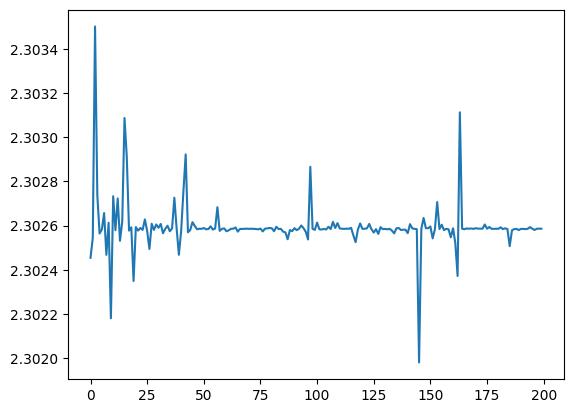

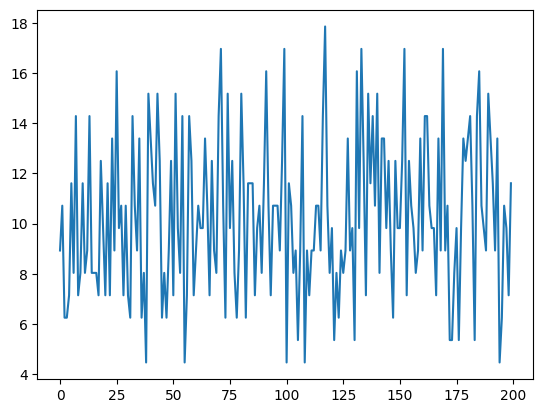

In [12]:
plt.plot([loss_i.cpu().detach() for loss_i in loss_list_epoch])
# plt.ylim(0.5, 2.5)
plt.show()


plt.plot(acc_list_epoch)
plt.show()

In [13]:
print([float(loss_i.cpu().detach()) for loss_i in loss_list_epoch])
print(acc_list_epoch)
# loss_list_epoch_ = [0.841748058795929, 0.5383376479148865, 0.37141960859298706, 0.2189747840166092, 0.2170722633600235, 0.2683789134025574, 0.1937561184167862, 0.2995546758174896, 0.13230514526367188, 0.12556131184101105, 0.08791607618331909, 0.13517722487449646, 0.1180429607629776, 0.2700677216053009, 0.23012836277484894, 0.11778731644153595, 0.08971132338047028, 0.0745047926902771, 0.044976893812417984, 0.030214795842766762, 0.14274518191814423, 0.16257527470588684, 0.13489486277103424, 0.22497442364692688, 0.04410076141357422, 0.0439407117664814, 0.0999048724770546, 0.09295899420976639, 0.05333646386861801, 0.042801376432180405, 0.0852958932518959, 0.035196453332901, 0.09896297752857208, 0.09667126089334488, 0.11132311820983887, 0.07094293087720871, 0.11317868530750275, 0.17386971414089203, 0.04825839400291443, 0.1526862233877182, 0.12213451415300369, 0.0335562527179718, 0.14572270214557648, 0.14732243120670319, 0.08901072293519974, 0.10628568381071091, 0.1219853013753891, 0.04227989539504051, 0.1546023041009903, 0.07231778651475906, 0.08872615545988083, 0.06031284108757973, 0.11893129348754883, 0.07610543072223663, 0.05435555428266525, 0.03299633413553238, 0.06796611100435257, 0.09908641129732132, 0.1245361715555191, 0.13339823484420776, 0.044910043478012085, 0.039106521755456924, 0.08405368030071259, 0.03416334092617035, 0.18436889350414276, 0.06167331337928772, 0.05363277718424797, 0.03776988759636879, 0.010305949486792088, 0.08863425254821777, 0.11051689833402634, 0.03690870478749275, 0.021718373522162437, 0.08610344678163528, 0.08286675065755844, 0.05776119977235794, 0.09465332329273224, 0.032651614397764206, 0.07205092906951904, 0.0745658427476883, 0.08170061558485031, 0.10555801540613174, 0.016445361077785492, 0.12694816291332245, 0.11931197345256805, 0.08286337554454803, 0.07604096084833145, 0.04736681655049324, 0.07517056912183762, 0.13407494127750397, 0.02461135759949684, 0.026882896199822426, 0.050736844539642334, 0.03605273738503456, 0.056351643055677414, 0.09767205268144608, 0.07290007919073105, 0.08676333725452423, 0.0794496163725853, 0.04368472844362259, 0.050167299807071686, 0.04737326130270958, 0.05501176789402962, 0.08879045397043228, 0.01769072189927101, 0.11385718733072281, 0.045953329652547836, 0.057710688561201096, 0.03719104081392288, 0.07977698743343353, 0.02595260553061962, 0.1046842560172081, 0.06301649659872055, 0.02800893224775791, 0.024529291316866875, 0.020508909597992897, 0.14025148749351501, 0.05224132165312767, 0.02634393982589245, 0.03067580796778202, 0.010352589190006256, 0.030206164345145226, 0.09297139197587967, 0.1973668485879898, 0.11294060945510864, 0.10930002480745316, 0.0792819932103157, 0.11282505095005035, 0.06902279704809189, 0.034222979098558426, 0.01758032664656639, 0.20883719623088837, 0.0871180072426796, 0.021445829421281815, 0.058817390352487564, 0.11408091336488724, 0.04319537431001663, 0.028295835480093956, 0.009734376333653927, 0.0865861177444458, 0.013264675624668598, 0.03975219279527664, 0.03132316842675209, 0.07329122722148895, 0.031415101140737534, 0.057007454335689545, 0.07466187328100204, 0.03515228256583214, 0.01828647591173649, 0.034930113703012466, 0.04921986907720566, 0.05617351084947586, 0.025701504200696945, 0.07073844969272614, 0.0677885115146637, 0.0442965142428875, 0.08668070286512375, 0.01085565984249115, 0.10640285909175873, 0.042185988277196884, 0.045891039073467255, 0.010602300986647606, 0.07824820280075073, 0.029184645041823387, 0.1528889238834381, 0.0852082297205925, 0.01046351995319128, 0.26733046770095825, 0.008088228292763233, 0.1218838021159172, 0.06059052422642708, 0.17010393738746643, 0.09900021553039551, 0.027551589533686638, 0.009467942640185356, 0.0559978224337101, 0.015254249796271324, 0.06907999515533447, 0.026691734790802002, 0.09885875135660172, 0.01129892561584711, 0.03152812644839287, 0.08123517781496048, 0.04274165257811546, 0.03844240680336952, 0.06572488695383072, 0.10163140296936035, 0.020722707733511925, 0.016591958701610565, 0.10138952732086182, 0.10918857157230377, 0.028943251818418503, 0.04512939602136612, 0.040990330278873444, 0.04000023752450943, 0.045494887977838516, 0.011356256902217865, 0.05481533333659172, 0.013076278381049633, 0.04331720620393753]
# acc_list_epoch_ = [71.42857142857143, 83.03571428571429, 84.82142857142857, 95.53571428571429, 91.07142857142857, 91.96428571428571, 93.75, 91.96428571428571, 96.42857142857143, 94.64285714285714, 98.21428571428571, 93.75, 96.42857142857143, 92.85714285714286, 94.64285714285714, 96.42857142857143, 96.42857142857143, 97.32142857142857, 98.21428571428571, 99.10714285714286, 95.53571428571429, 95.53571428571429, 97.32142857142857, 91.96428571428571, 99.10714285714286, 99.10714285714286, 98.21428571428571, 95.53571428571429, 97.32142857142857, 98.21428571428571, 95.53571428571429, 98.21428571428571, 96.42857142857143, 96.42857142857143, 95.53571428571429, 98.21428571428571, 95.53571428571429, 97.32142857142857, 99.10714285714286, 93.75, 95.53571428571429, 98.21428571428571, 94.64285714285714, 95.53571428571429, 97.32142857142857, 95.53571428571429, 94.64285714285714, 98.21428571428571, 96.42857142857143, 97.32142857142857, 97.32142857142857, 98.21428571428571, 97.32142857142857, 97.32142857142857, 97.32142857142857, 99.10714285714286, 98.21428571428571, 97.32142857142857, 96.42857142857143, 96.42857142857143, 98.21428571428571, 98.21428571428571, 95.53571428571429, 99.10714285714286, 94.64285714285714, 97.32142857142857, 97.32142857142857, 98.21428571428571, 100.0, 97.32142857142857, 95.53571428571429, 98.21428571428571, 100.0, 97.32142857142857, 96.42857142857143, 99.10714285714286, 98.21428571428571, 99.10714285714286, 99.10714285714286, 98.21428571428571, 95.53571428571429, 96.42857142857143, 99.10714285714286, 98.21428571428571, 94.64285714285714, 97.32142857142857, 96.42857142857143, 98.21428571428571, 95.53571428571429, 93.75, 100.0, 99.10714285714286, 98.21428571428571, 99.10714285714286, 98.21428571428571, 96.42857142857143, 97.32142857142857, 97.32142857142857, 97.32142857142857, 99.10714285714286, 99.10714285714286, 98.21428571428571, 97.32142857142857, 96.42857142857143, 99.10714285714286, 95.53571428571429, 98.21428571428571, 96.42857142857143, 98.21428571428571, 98.21428571428571, 99.10714285714286, 97.32142857142857, 97.32142857142857, 98.21428571428571, 99.10714285714286, 99.10714285714286, 93.75, 97.32142857142857, 99.10714285714286, 98.21428571428571, 100.0, 99.10714285714286, 95.53571428571429, 91.07142857142857, 95.53571428571429, 95.53571428571429, 95.53571428571429, 96.42857142857143, 97.32142857142857, 98.21428571428571, 99.10714285714286, 94.64285714285714, 98.21428571428571, 100.0, 98.21428571428571, 97.32142857142857, 98.21428571428571, 98.21428571428571, 100.0, 96.42857142857143, 100.0, 98.21428571428571, 98.21428571428571, 97.32142857142857, 99.10714285714286, 98.21428571428571, 97.32142857142857, 99.10714285714286, 99.10714285714286, 98.21428571428571, 99.10714285714286, 99.10714285714286, 99.10714285714286, 95.53571428571429, 98.21428571428571, 99.10714285714286, 98.21428571428571, 100.0, 97.32142857142857, 97.32142857142857, 98.21428571428571, 100.0, 96.42857142857143, 99.10714285714286, 96.42857142857143, 97.32142857142857, 100.0, 91.96428571428571, 100.0, 96.42857142857143, 97.32142857142857, 91.96428571428571, 97.32142857142857, 99.10714285714286, 100.0, 96.42857142857143, 99.10714285714286, 98.21428571428571, 99.10714285714286, 96.42857142857143, 100.0, 99.10714285714286, 99.10714285714286, 97.32142857142857, 99.10714285714286, 98.21428571428571, 97.32142857142857, 100.0, 100.0, 95.53571428571429, 94.64285714285714, 99.10714285714286, 97.32142857142857, 98.21428571428571, 98.21428571428571, 98.21428571428571, 100.0, 98.21428571428571, 100.0, 99.10714285714286]

[2.3024542331695557, 2.302544355392456, 2.3035008907318115, 2.3027381896972656, 2.3025641441345215, 2.302582263946533, 2.302656650543213, 2.3024675846099854, 2.302612543106079, 2.302180528640747, 2.3027327060699463, 2.302579164505005, 2.302722692489624, 2.3025310039520264, 2.3026180267333984, 2.303086757659912, 2.3029119968414307, 2.302577257156372, 2.3025920391082764, 2.302349090576172, 2.302593231201172, 2.302577257156372, 2.302589178085327, 2.3025805950164795, 2.3026280403137207, 2.3025755882263184, 2.3024940490722656, 2.3026082515716553, 2.3025803565979004, 2.302604913711548, 2.3025898933410645, 2.302607297897339, 2.302565097808838, 2.3025853633880615, 2.3025991916656494, 2.3025741577148438, 2.3025872707366943, 2.3027260303497314, 2.302586793899536, 2.3024678230285645, 2.3025755882263184, 2.302755355834961, 2.302922010421753, 2.302569627761841, 2.302579641342163, 2.3026154041290283, 2.302598237991333, 2.3025834560394287, 2.3025858402252197, 2.3025851249694824, 2.302588939666748, 2.

In [14]:
# Testing train loop
qt_model.eval()
correct = 0
total = 0
loss_train_list = []
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = qt_model(images, qnn_parameters)
        loss_train = criterion(outputs, labels).cpu().detach().numpy()
        loss_train_list.append(loss_train)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the train set: {(100 * correct / total):.2f}%")
print(f"Loss on the train set: {np.mean(loss_train_list):.2f}")

# Testing loop
qt_model.eval()
correct = 0
total = 0
loss_test_list = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = qt_model(images, qnn_parameters)
        loss_test = criterion(outputs, labels).cpu().detach().numpy()
        loss_test_list.append(loss_test)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {(100 * correct / total):.2f}%")
print(f"Loss on the test set: {np.mean(loss_test_list):.2f}")

print("Generalization error:", np.mean(loss_test_list) - np.mean(loss_train_list))

Accuracy on the train set: 10.15%
Loss on the train set: 2.30
Accuracy on the test set: 10.33%
Loss on the test set: 2.30
Generalization error: 2.3841858e-07


In [15]:
# # Testing train loop
# model.eval()
# correct = 0
# total = 0
# loss_train_list = []
# with torch.no_grad():
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)  # Move data to GPU
#         outputs = model(images)
#         loss_train = criterion(outputs, labels).cpu().detach().numpy()
#         loss_train_list.append(loss_train)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f"Accuracy on the train set: {(100 * correct / total):.2f}%")
# print(f"Loss on the train set: {np.mean(loss_train_list):.2f}")

# # Testing loop
# model.eval()
# correct = 0
# total = 0
# loss_test_list = []

# with torch.no_grad():
#     for images, labels in val_loader:
#         images, labels = images.to(device), labels.to(device)  # Move data to GPU
#         outputs = model(images)
#         loss_test = criterion(outputs, labels).cpu().detach().numpy()
#         loss_test_list.append(loss_test)

#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f"Accuracy on the test set: {(100 * correct / total):.2f}%")
# print(f"Loss on the test set: {np.mean(loss_test_list):.2f}")

# print("Generalization error:", np.mean(loss_test_list) - np.mean(loss_train_list))

In [16]:
# def fit(
#     epochs: int,
#     lr: float,
#     model: torch.nn.Module,
#     train_loader: DataLoader,
#     val_loader: DataLoader,
#     bs: BosonSampler,
#     opt_func=torch.optim.SGD,
#     save_csv: bool = True,
#     csv_path: str = "training_history"
# ):
#     """
#     Trains the model for a specified number of epochs, evaluates on validation data,
#     and optionally saves the training history to a CSV file with a timestamp.

#     Args:
#         epochs (int): Number of epochs to train.
#         lr (float): Learning rate.
#         model (torch.nn.Module): The neural network model to train.
#         train_loader (DataLoader): DataLoader for training data.
#         val_loader (DataLoader): DataLoader for validation data.
#         bs (BosonSampler): BosonSampler instance for embedding.
#         opt_func (torch.optim.Optimizer, optional): Optimizer constructor. Defaults to torch.optim.SGD.
#         save_csv (bool, optional): Whether to save the training history to a CSV file. Defaults to True.
#         csv_path (str, optional): Base path/name for the CSV file. A timestamp will be appended. Defaults to "training_history".

#     Returns:
#         dict: A dictionary containing training and validation metrics per epoch.
#     """
#     # Initialize optimizer
#     optimizer = opt_func(model.parameters(), lr=lr)
#     criterion = torch.nn.CrossEntropyLoss()

#     # Initialize history dictionary
#     history = {
#         'epoch': [],
#         'train_loss': [],
#         'train_acc': [],
#         'val_loss': [],
#         'val_acc': []
#     }

#     # Determine the device from the model
#     device = next(model.parameters()).device
#     print(f"Training on device: {device}")

#     # Create a progress bar for epochs
#     epoch_bar = tqdm(range(1, epochs + 1), desc="Training Progress", unit="epoch")

#     for epoch in epoch_bar:
#         model.train()
#         running_loss = 0.0
#         running_corrects = 0
#         total_samples = 0

#         # Iterate over training data
#         for batch in train_loader:
#             if model.embedding_size:
#                 images, labels = batch
#                 # Move images and labels to the device
#                 images = images.to(device)
#                 labels = labels.to(device)

#                 # Generate embeddings and move them to the device
#                 embs = bs.embed(images, n_sample=1000).to(device)

#                 # Forward pass with embeddings
#                 outputs = model(images, emb=embs.unsqueeze(0))
#             else:
#                 images, labels = batch
#                 # Move images and labels to the device
#                 images = images.to(device)
#                 labels = labels.to(device)

#                 # Forward pass without embeddings
#                 outputs = model(images)

#             # Compute loss
#             loss = criterion(outputs, labels)

#             # Compute accuracy
#             _, preds = torch.max(outputs, 1)
#             acc = torch.sum(preds == labels.data).item()

#             # Backward pass and optimization
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             # Accumulate loss and accuracy
#             running_loss += loss.item() * images.size(0)
#             running_corrects += acc
#             total_samples += images.size(0)

#         # Calculate epoch metrics
#         epoch_train_loss = running_loss / total_samples
#         epoch_train_acc = running_corrects / total_samples

#         # Validation phase
#         model.eval()
#         val_running_loss = 0.0
#         val_running_corrects = 0
#         val_total_samples = 0

#         with torch.no_grad():
#             for batch in val_loader:
#                 if model.embedding_size:
#                     images, labels = batch
#                     # Move images and labels to the device
#                     images = images.to(device)
#                     labels = labels.to(device)

#                     # Generate embeddings and move them to the device
#                     embs = bs.embed(images, n_sample=1000).to(device)

#                     # Forward pass with embeddings
#                     outputs = model(images, emb=embs.unsqueeze(0))
#                 else:
#                     images, labels = batch
#                     # Move images and labels to the device
#                     images = images.to(device)
#                     labels = labels.to(device)

#                     # Forward pass without embeddings
#                     outputs = model(images)

#                 # Compute loss
#                 loss = criterion(outputs, labels)

#                 # Compute accuracy
#                 _, preds = torch.max(outputs, 1)
#                 acc = torch.sum(preds == labels.data).item()

#                 # Accumulate loss and accuracy
#                 val_running_loss += loss.item() * images.size(0)
#                 val_running_corrects += acc
#                 val_total_samples += images.size(0)

#         # Calculate validation metrics
#         epoch_val_loss = val_running_loss / val_total_samples
#         epoch_val_acc = val_running_corrects / val_total_samples

#         # Update history
#         history['epoch'].append(epoch)
#         history['train_loss'].append(epoch_train_loss)
#         history['train_acc'].append(epoch_train_acc)
#         history['val_loss'].append(epoch_val_loss)
#         history['val_acc'].append(epoch_val_acc)

#         # Update the progress bar description
#         epoch_bar.set_postfix({
#             'Train Loss': f"{epoch_train_loss:.4f}",
#             'Train Acc': f"{epoch_train_acc:.4f}",
#             'Val Loss': f"{epoch_val_loss:.4f}",
#             'Val Acc': f"{epoch_val_acc:.4f}"
#         })

#     # Save history to CSV with timestamp
#     if save_csv:
#         timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#         csv_filename = f"{csv_path}_{timestamp}.csv"
#         history_df = pd.DataFrame(history)
#         history_df.to_csv(csv_filename, index=False)
#         print(f"\nTraining history saved to '{csv_filename}'.")

#     return history